In [1]:
import sys
sys.path.append('..')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

from losses import MSE
from run_utils import setup
from configs import vae_wrapper_config as config
from utils import notebook_select_gpu, load_depth_data, load_apollo_data, \
    get_normalized_ds, visualize_vae_depth_map, plot_roc, gen_ood_comparison

notebook_select_gpu(0, False)

4 Physical GPUs, 1 Logical GPU


## Manual (one by one)

In [3]:
(x_train, y_train), (x_test, y_test) = load_depth_data()

ds_train = get_normalized_ds(x_train[:config.N_TRAIN], y_train[:config.N_TRAIN], shuffle=False)
ds_test = get_normalized_ds(x_test, y_test, shuffle=False)

_, (x_ood, y_ood) = load_apollo_data()
ds_ood = get_normalized_ds(x_ood, y_ood, shuffle=False)

2022-09-28 13:46:07.217984: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.72GiB (rounded to 6144000000)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-09-28 13:46:07.218077: W tensorflow/core/common_runtime/bfc_allocator.cc:491] <allocator contains no memory>


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

### Load trained model

In [408]:
from utils import load_model, select_best_checkpoint

model_name = 'notebook_vae'
path, checkpoints_path, vis_path, plots_path, logs_path = setup(model_name)

# path, _ = select_best_checkpoint('/home/iaroslavelistratov/results/ae/20220918-171841-new-latent20')
path, _ = select_best_checkpoint('/home/iaroslavelistratov/results/vae/20220925-213316-new_callback_sample_same-latent_20')
vae_model = load_model(path, model_name, ds_train, opts={'latent_dim':20}, quite=False)

encoder-inputs:  (None, 128, 160, 3)
encoder-pool1:  (None, 64, 80, 32)
encoder-pool2:  (None, 32, 40, 64)
encoder-pool3:  (None, 16, 20, 128)
encoder-pool4:  (None, 8, 10, 256)
encoder-pool5:  (None, 4, 5, 256)
encoder-conv6:  (None, 4, 5, 256)
encoder-conv7:  (None, 4, 5, 128)
encoder-conv8:  (None, 4, 5, 64)
encoder_trainable_count 4239624
encoder_non_trainable_count 0
decoder-conv8:  (None, 4, 5, 64)
decoder-conv7:  (None, 4, 5, 128)
decoder-conv6:  (None, 4, 5, 256)
decoder-conv5:  (None, 4, 5, 256)
decoder-conv4:  (None, 8, 10, 256)
decoder-conv3:  (None, 16, 20, 128)
decoder-conv2:  (None, 32, 40, 64)
decoder-conv1:  (None, 64, 80, 32)
decoder-conv0:  (None, 128, 160, 16)
decoder_trainable_count 3509939
decoder_non_trainable_count 0
Successfully loaded weights from /home/iaroslavelistratov/results/vae/20220925-213316-new_callback_sample_same-latent_20/checkpoints/0.011289vloss_48484iter.tf.


In [5]:
from utils import load_model, select_best_checkpoint

model_name = 'notebook_ae'
path, checkpoints_path, vis_path, plots_path, logs_path = setup(model_name)

# path, _ = select_best_checkpoint('/home/iaroslavelistratov/results/ae/20220918-171841-new-latent20')
path, _ = select_best_checkpoint('/home/iaroslavelistratov/results/ae/20220925-180115-new_callback_sample_same-latent_20')
ae_model = load_model(path, model_name, ds_train, opts={'latent_dim':20}, quite=False)

encoder-inputs:  (None, 128, 160, 3)
encoder-pool1:  (None, 64, 80, 32)
encoder-pool2:  (None, 32, 40, 64)
encoder-pool3:  (None, 16, 20, 128)
encoder-pool4:  (None, 8, 10, 256)
encoder-pool5:  (None, 4, 5, 256)
encoder-conv6:  (None, 4, 5, 256)
encoder-conv7:  (None, 4, 5, 128)
encoder-conv8:  (None, 4, 5, 64)
encoder_trainable_count 4239624
encoder_non_trainable_count 0
decoder-conv8:  (None, 4, 5, 64)
decoder-conv7:  (None, 4, 5, 128)
decoder-conv6:  (None, 4, 5, 256)
decoder-conv5:  (None, 4, 5, 256)
decoder-conv4:  (None, 8, 10, 256)
decoder-conv3:  (None, 16, 20, 128)
decoder-conv2:  (None, 32, 40, 64)
decoder-conv1:  (None, 64, 80, 32)
decoder-conv0:  (None, 128, 160, 16)
decoder_trainable_count 3509939
decoder_non_trainable_count 0
Successfully loaded weights from /home/iaroslavelistratov/results/ae/20220925-180115-new_callback_sample_same-latent_20/checkpoints/0.011374vloss_45356iter.tf.


In [ ]:
model_name = 'notebook_dropout'
path, checkpoints_path, vis_path, plots_path, logs_path = setup(model_name)

# path, model_name = select_best_checkpoint('/home/iaroslavelistratov/results/dropout/20220918-220234new')
path, model_name = select_best_checkpoint('/home/iaroslavelistratov/results/dropout/20220925-121720-new_callback')
dropout_model = load_model(path, model_name, ds_train, quite=False)

Successfully loaded weights from /home/iaroslavelistratov/results/dropout/20220925-121720-new_callback/checkpoints/0.002752vloss_57868iter.tf.


In [ ]:
path, model_name = select_best_checkpoint('/home/iaroslavelistratov/results/mve/20220925-173748-new_callback_sample_same')
mve_model = load_model(path, model_name, ds_train, quite=False)

##

### OOD plot

In [24]:
# # sanity check -- on train
# dropout_train, dropout_ood = gen_ood_comparison(ds_train, ds_ood, dropout_model, T=2, reduce='per_img', is_show=True, is_return=True)
# plot_roc(dropout_train, dropout_ood, model_name='Train vs OOD - Dropout')

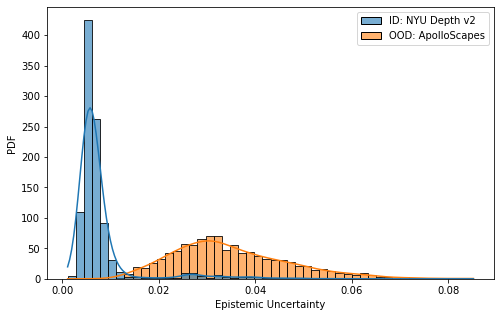

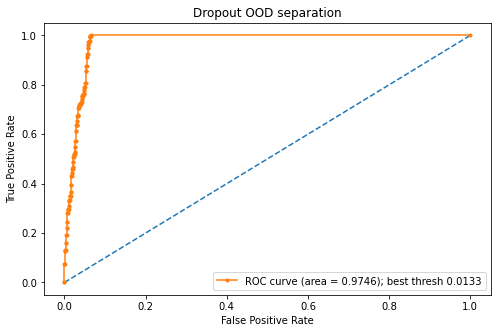

In [55]:
dropout_iid, dropout_ood = gen_ood_comparison(ds_test, ds_ood, dropout_model, T=5, reduce='per_img', is_show=True, is_return=True)
auc_dropout = plot_roc(dropout_iid, dropout_ood, model_name='Dropout', is_return=True)

In [56]:
# # sanity check -- on train
# ae_train, ae_ood = gen_ood_comparison(ds_train, ds_ood, ae_model, reduce='per_img', is_show=True, is_return=True)
# plot_roc(ae_train, ae_ood, model_name='Train vs OOD - AE')

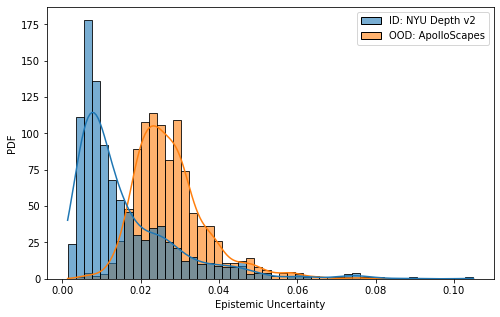

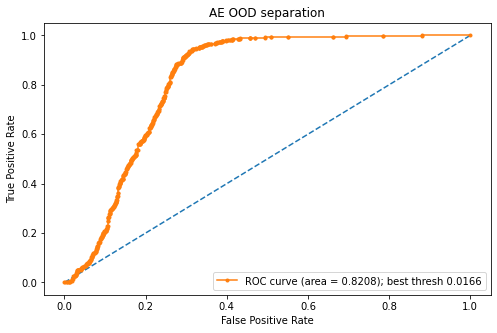

In [57]:
ae_iid, ae_ood = gen_ood_comparison(ds_test, ds_ood, ae_model, reduce='per_img', is_show=True, is_return=True)
plot_roc(ae_iid, ae_ood, model_name='AE')

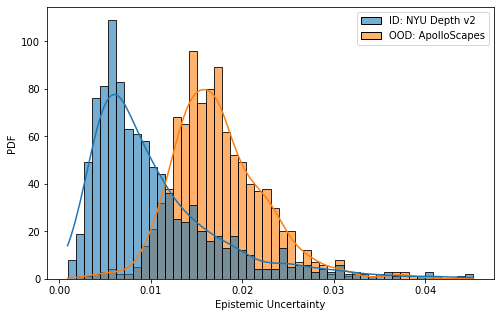

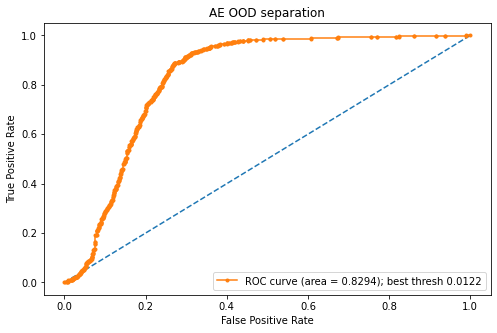

In [58]:
vae_iid, vae_ood = gen_ood_comparison(ds_test, ds_ood, vae_model, T=5, reduce='per_img', is_show=True, is_return=True)
plot_roc(vae_iid, vae_ood, model_name='AE')

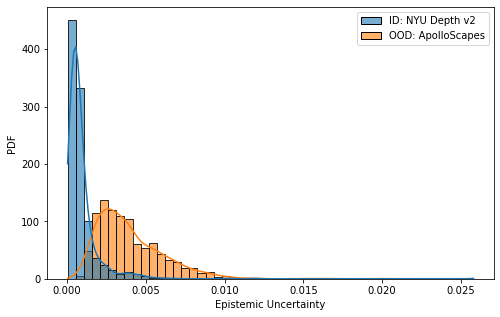

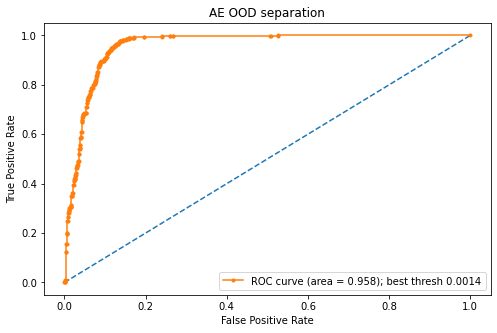

In [71]:
mve_iid, mve_ood = gen_ood_comparison(ds_test, ds_ood, mve_model, reduce='per_img', is_show=True, is_return=True)
plot_roc(mve_iid, mve_ood, model_name='AE')

### Normalize

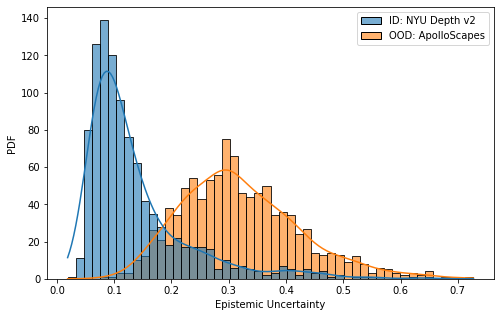

In [73]:
# def min_max_norm(x):
#     return (x - tf.reduce_min(x)) / (tf.reduce_max(x) - tf.reduce_min(x))

# note: vae or ae
# combined_iid = tf.reduce_mean(tf.stack([min_max_norm(dropout_iid), min_max_norm(vae_iid)], axis=0), axis=0)
# combined_ood = tf.reduce_mean(tf.stack([min_max_norm(dropout_ood), min_max_norm(vae_ood)], axis=0), axis=0)

# df = pd.DataFrame({'ID: NYU Depth v2': combined_iid, 'OOD: ApolloScapes' : combined_ood})

# fig, ax = plt.subplots(figsize=(8, 5))  
# plot = sns.histplot(data=df, kde=True, bins=50, alpha=0.6);
# plot.set(xlabel='Epistemic Uncertainty', ylabel='PDF');

# plt.show()

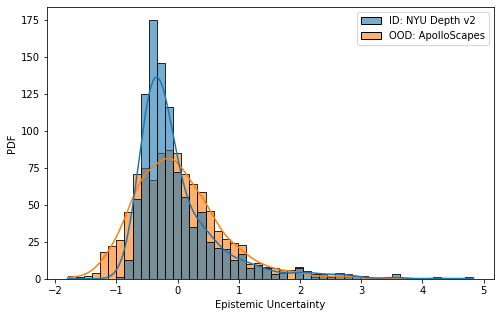

In [80]:
# def standardization(x):
#     return (x - np.mean(x)) / np.std(x)

# note: vae or ae
# combined_iid = tf.reduce_mean(tf.stack([standardization(dropout_iid), standardization(vae_iid)], axis=0), axis=0)
# combined_ood = tf.reduce_mean(tf.stack([standardization(dropout_ood), standardization(vae_ood)], axis=0), axis=0)

# df = pd.DataFrame({'ID: NYU Depth v2': combined_iid, 'OOD: ApolloScapes' : combined_ood})

# fig, ax = plt.subplots(figsize=(8, 5))  
# plot = sns.histplot(data=df, kde=True, bins=50, alpha=0.6);
# plot.set(xlabel='Epistemic Uncertainty', ylabel='PDF');

# plt.show()

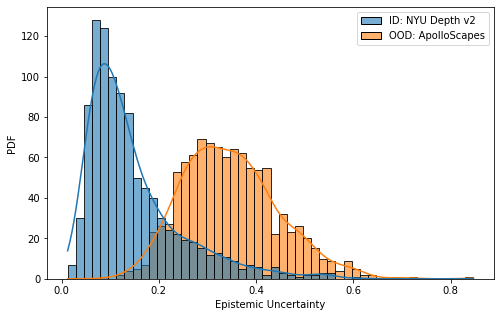

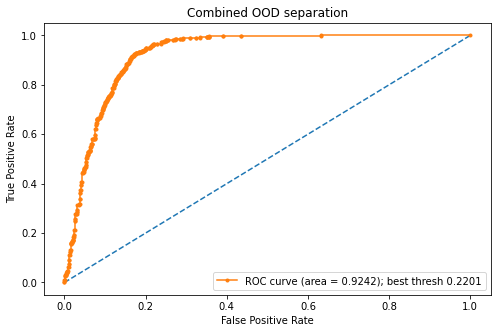

In [109]:
# def normalization_0to1(x):
#     return (x - np.min(x))/np.ptp(x)

# # note: vae or ae
# combined_iid = tf.reduce_mean(tf.stack([normalization_0to1(dropout_iid), normalization_0to1(vae_iid)], axis=0), axis=0)
# combined_ood = tf.reduce_mean(tf.stack([normalization_0to1(dropout_ood), normalization_0to1(vae_ood)], axis=0), axis=0)

# df = pd.DataFrame({'ID: NYU Depth v2': combined_iid, 'OOD: ApolloScapes' : combined_ood})
# fig, ax = plt.subplots(figsize=(8, 5))  
# plot = sns.histplot(data=df, kde=True, bins=50, alpha=0.6);
# plot.set(xlabel='Epistemic Uncertainty', ylabel='PDF');
# plt.show()

# auc_combined = plot_roc(combined_iid, combined_ood, model_name='Combined', is_return=True)

In [110]:
# round((auc_combined - auc_dropout) * 100, 3)

-5.18

### Weighted sum

In [3]:
def find_weights(m1_iid, m1_ood, m2_iid, m2_ood, is_return=False):
    weights = np.arange(0.0, 1.01, 0.01)
    dic = {}
    for w in weights:
        combined_iid = ((1 - w) * m1_iid + w * m2_iid)
        combined_ood = ((1 - w) * m1_ood + w * m2_ood)
        _, _, auc = plot_roc(combined_iid, combined_ood, model_name='AE + Dropout', is_show=False, is_return=True)
        dic[auc] = [(1-w), w]

    m1 = list(dic.keys())[0]
    print('m1 alone: ', round(m1 * 100, 3), dic[m1])
    m2 = list(dic.keys())[-1]
    print('m2 alone: ', round(m2 * 100, 3), dic[m2])

    auc_max = max(list(dic.keys()))
    print('best: ', round(auc_max * 100, 3), dic[auc_max])

    print(f'\nimprovement in comparison to m1 is: {round((auc_max - m1) * 100, 3)} ')
    print(f'improvement in comparison to m2 is: {round((auc_max - m2) * 100, 3)} ')

    if is_return:
        return dic[auc_max] # list of len 2

In [ ]:
find_weights(dropout_iid, dropout_ood, vae_iid, vae_ood)

In [75]:
find_weights(dropout_iid, dropout_ood, mve_iid, mve_ood)

m1 alone:  97.46 [0.99, 0.01]
m2 alone:  95.8 [0.0, 1.0]
best:  98.92 [0.13, 0.87]

improvement in comparison to m1 is: 1.46 
improvement in comparison to m2 is: 3.12 


In [76]:
find_weights(vae_iid, vae_ood, mve_iid, mve_ood)

m1 alone:  82.94 [1.0, 0.0]
m2 alone:  95.8 [0.0, 1.0]
best:  96.55 [0.04999999999999993, 0.9500000000000001]

improvement in comparison to m1 is: 13.61 
improvement in comparison to m2 is: 0.75 


In [77]:
find_weights(ae_iid, ae_ood, mve_iid, mve_ood)

m1 alone:  82.08 [1.0, 0.0]
m2 alone:  95.8 [0.0, 1.0]
best:  96.28 [0.030000000000000027, 0.97]

improvement in comparison to m1 is: 14.2 
improvement in comparison to m2 is: 0.48 


## Loop (reading dataframes)

### Single models

In [4]:
import scipy.stats as st

def confidence_interval_95(a, str_quantity, str_model_name, ci=0.95, is_return=False):
    sample_size = len(a) - 1
    standard_error = st.sem(a)
    lower_cutoff, upper_cutoff = st.t.interval(ci, sample_size, loc=np.mean(a), scale=standard_error)

    check1 = np.mean(a) - lower_cutoff
    check2 = upper_cutoff - np.mean(a)
    # second condition is needed when passing exactly same datapoints in a (I sometimes do this as a sanity check)
    assert np.isclose(check1, check2) or (np.isnan(check1) and np.isnan(check1))
    print(f'{str_model_name} {str_quantity} is {round(np.mean(a), 5)} ± {round(check1, 5)}')

    if is_return:
        return round(np.mean(a), 5), round(check1, 5)

In [5]:
import glob

num_models = 4
results_path = '/home/iaroslavelistratov/results/'

d = {}
for model_name in ['vae', 'ensemble', 'mve', 'dropout', 'base']:

    model_path = results_path + model_name
    all_initializations = glob.glob(model_path + '/*')
    relevant_initializations = [i for i in all_initializations if 'new_callback' in i]
    assert len(relevant_initializations) == num_models, relevant_initializations

    d[model_name] = relevant_initializations

d

{'vae': ['/home/iaroslavelistratov/results/vae/20220925-034026-new_callback-latent_20',
  '/home/iaroslavelistratov/results/vae/20220926-104431-new_callback_sample_same-latent_20',
  '/home/iaroslavelistratov/results/vae/20220925-213316-new_callback_sample_same-latent_20',
  '/home/iaroslavelistratov/results/vae/20220925-195552-new_callback_sample_same-latent_20'],
 'ensemble': ['/home/iaroslavelistratov/results/ensemble/20220924-160011-new_callback-4_members',
  '/home/iaroslavelistratov/results/ensemble/20220926-103111-new_callback-4_members',
  '/home/iaroslavelistratov/results/ensemble/20220925-031122-new_callback-4_members',
  '/home/iaroslavelistratov/results/ensemble/20220925-114728-new_callback-4_members'],
 'mve': ['/home/iaroslavelistratov/results/mve/20220925-193346-new_callback_sample_same',
  '/home/iaroslavelistratov/results/mve/20220925-173748-new_callback_sample_same',
  '/home/iaroslavelistratov/results/mve/20220926-103158-new_callback_sample_same',
  '/home/iaroslavel

######## vae ########


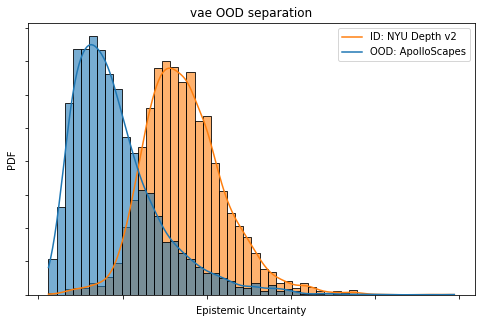

vae roc is 0.88551 ± 0.03614
######## ensemble ########
ensemble test_loss is 0.00233 ± 7e-05


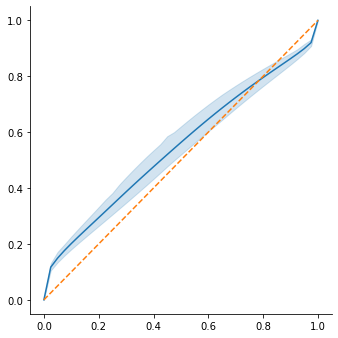

ensemble calibration_mse_ci=75 is 0.06129 ± 0.02172


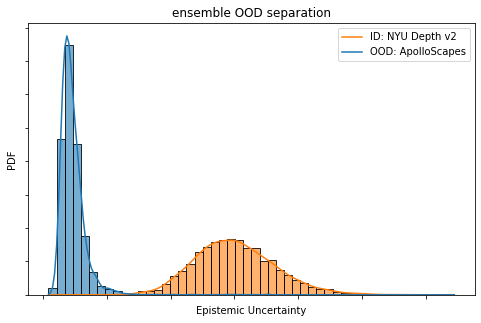

ensemble roc is 0.99887 ± 0.00178
######## mve ########
mve test_loss is 0.00363 ± 0.00101


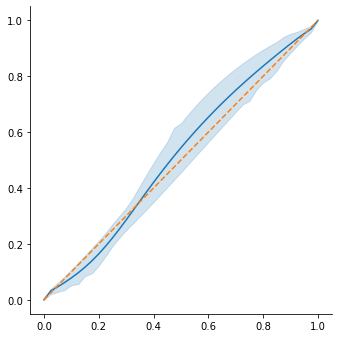

mve calibration_mse_ci=75 is 0.05325 ± 0.02246


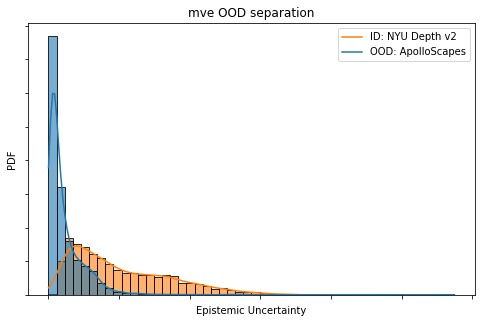

mve roc is 0.9798 ± 0.01181
######## dropout ########
dropout test_loss is 0.0027 ± 0.00012


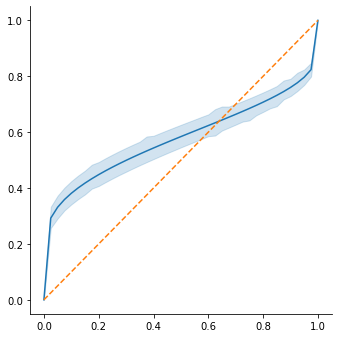

dropout calibration_mse_ci=75 is 0.13973 ± 0.01231


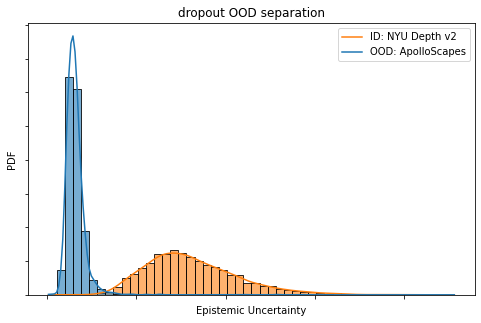

dropout roc is 0.99864 ± 0.0026
######## base ########
base test_loss is 0.00265 ± 0.00016


In [6]:
figs_path = '/home/iaroslavelistratov/results/figs'

for model_name, paths in d.items():

    print(f'######## {model_name} ########')
    l_fpr = []
    l_tpr = []
    l_calibration_mse = []
    l_combined_roc = []
    l_combined_df_loss = []
    l_combined_df_calibration = []
    l_combined_df_ood = []
    for idx, curr_path in enumerate(paths):
        cache_dir = curr_path + '/cached'

        # 1/3
        if model_name in ['dropout', 'mve', 'ensemble', 'base']:
            df_loss = pd.read_csv(cache_dir + '/df_loss.csv')
            df_loss = df_loss.set_axis(['loss'], axis=1, inplace=False)
            l_combined_df_loss.append(df_loss)
        # 2/3
        if model_name not in ['base', 'vae']:
            df_calibration = pd.read_csv(cache_dir + '/df_calibration.csv')
            # need columns to have same name in order to later concat on axis zero 
            df_calibration = df_calibration.set_axis(['percentiles', 'vals'], axis=1, inplace=False)
            l_combined_df_calibration.append(df_calibration)

            vals = df_calibration['vals']
            percentiles = df_calibration['percentiles']
            # mse = MSE(percentiles, vals).numpy()
            mse = np.mean(abs(percentiles - vals))
            l_calibration_mse.append(mse)

        # 2/3
        if model_name not in ['base']:
            df_ood = pd.read_csv(cache_dir + '/df_ood.csv')
            df_ood = df_ood.set_axis(['id', 'od'], axis=1, inplace=False)
            l_combined_df_ood.append(df_ood)

            fpr, tpr, roc_auc = plot_roc(df_ood['id'], df_ood['od'], model_name, is_show=False, is_return=True, path=f'{figs_path}/roc_{model_name}')
            df_roc = pd.DataFrame([roc_auc], columns=['roc'])
            l_fpr.append(fpr)
            l_tpr.append(tpr)

            l_combined_roc.append(df_roc)

        # print(f'cached: {model_name}-{idx}')

            # df_calibration = pd.read_csv(cache_dir + '/df_calibration.csv')
            # l_combined_df_calibration.append(df_calibration)

    # combined_df_loss = pd.concat(l_combined_df_loss, axis=1)
    # combined_df_calibration = pd.concat(l_combined_df_calibration, axis=1)
    # combined_df_ood = pd.concat(l_combined_df_ood, axis=1)

    if model_name in ['dropout', 'mve', 'ensemble', 'base']:
        combined_df_loss = pd.concat(l_combined_df_loss, axis=0, ignore_index=True)
        confidence_interval_95(combined_df_loss['loss'], 'test_loss', model_name)

    if model_name not in ['base', 'vae']:
        combined_df_calibration = pd.concat(l_combined_df_calibration, axis=0, ignore_index=True)

        # By default, the resulting plot shows the mean and 95% CI for each unit
        plot = sns.relplot(data=combined_df_calibration, x="percentiles", y="vals", ci=95, kind="line", color='#1f77b4')
        plt.plot([0,1], [0,1], linestyle='--', color='#ff7f0e')
        plot.set(xlabel='', ylabel='');
        plt.savefig(f'{figs_path}/calibration_95CI_{model_name}.pdf', bbox_inches='tight', format='pdf')
        plt.show()

        # todo-high: note 75% CI
        confidence_interval_95(np.array(l_calibration_mse), 'calibration_mse_ci=75', model_name, ci=0.75)

    if model_name not in ['base']:
        combined_df_ood = pd.concat(l_combined_df_ood, axis=0, ignore_index=True)
        combined_df_roc = pd.concat(l_combined_roc, axis=0, ignore_index=True)

        fig, ax = plt.subplots(figsize=(8, 5))
        plt.title(f'{model_name} OOD separation')
        plot = sns.histplot(data=combined_df_ood, kde=True, bins=50, alpha=0.6);
        plot.set(xlabel='Epistemic Uncertainty', ylabel='PDF');
        ax.legend(['ID: NYU Depth v2', 'OOD: ApolloScapes'])
        plot.set(xticklabels=[]);
        plot.set(yticklabels=[]);
        plt.savefig(f'{figs_path}/ood_separation_{model_name}.pdf', bbox_inches='tight', format='pdf')
        plt.show()

        confidence_interval_95(combined_df_roc['roc'], 'roc', model_name)

In [ ]:
# # # note each eliment in the list has different num of elemeiments (points in the auc plot)
# arr_fpr = np.array([l_fpr[0][:], l_fpr[1][:], l_fpr[3][:], l_fpr[3][:]])
# arr_tpr = np.array([l_tpr[0][:], l_tpr[1][:], l_tpr[3][:], l_tpr[3][:]])

In [ ]:
combined_df_calibration = pd.concat(l_combined_df_calibration, axis=0, ignore_index=True)
a  = combined_df_calibration["vals"].values
a = np.reshape(a, (4, 41))

In [7]:
# same as confidence_interval_95 func but in two dims

sample_size = len(a) - 1
standard_error = st.sem(a, axis=0)
# note: to reproduce plot = sns.relplot(data=combined_df_calibration, x="percentiles", y="vals", kind="line", color='#1f77b4') use 0.75 below
lower_cutoff, upper_cutoff = st.t.interval(0.95, sample_size, loc=np.mean(a, axis=0), scale=standard_error)

check1 = np.mean(a, axis=0) - lower_cutoff
check2 = upper_cutoff - np.mean(a, axis=0)
# second condition is needed when passing exactly same datapoints in a (I sometimes do this as a sanity check)
np.testing.assert_allclose(check1, check2)
# print(f'is {round(np.mean(a, axis=0), 5)} ± {round(check1, 5)}')

NameError: name 'a' is not defined

In [ ]:
fig, ax = plt.subplots(figsize=(5.4, 5.6))

plt.plot(
    np.arange(41)/40,
    np.mean(a, axis=0),
    label="mean",
)

for i in range(4):
    plt.plot(
        np.arange(41)/40,
        a[i],
        label=i,
    )

plt.fill_between(
    np.arange(41)/40, 
    lower_cutoff,
    upper_cutoff,
    alpha=0.2,
    color='#1f77b4', #'r',
    linestyle='-', 
    linewidth=2,
    label="95 CI"
)

plt.plot([0,1], [0,1], linestyle='--', color='#ff7f0e')

plt.legend();

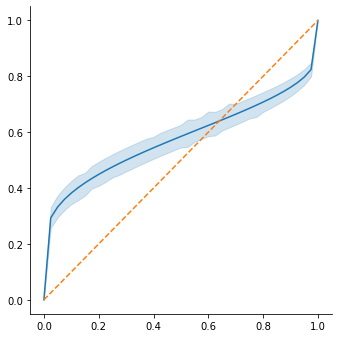

In [16]:
plot = sns.relplot(data=combined_df_calibration, x="percentiles", y="vals", kind="line", color='#1f77b4', ci=95)
plt.plot([0,1], [0,1], linestyle='--', color='#ff7f0e')
plot.set(xlabel='', ylabel='');

# confidence_interval_95(np.array(l_calibration_mse), 'calibration_mse', model_name)
# print(l_calibration_mse)

In [ ]:
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Random numbers for plotting
# x = np.random.uniform(-2, 2, 1000)
# y = np.random.normal(x**2, np.abs(x) + 1)

# # Manual binning to retain control
# binwidth = 4 / 10
# x_bins = np.arange(binwidth/2 - 2, 2, binwidth)
# sns.regplot(x=x, y=y, x_bins=x_bins, fit_reg=None)

# ax = plt.gca()
# lower = [line.get_ydata().min() for line in ax.lines]
# upper = [line.get_ydata().max() for line in ax.lines]
# lower

In [185]:
# a = np.array([0.011816204183164095, 0.011816204183164095, 0.011816204183164095, 0.011816204183164095])

# sample_size = len(a) - 1
# standard_error = st.sem(a)
# lower_cutoff, upper_cutoff = st.t.interval(0.95, sample_size, loc=np.mean(a), scale=standard_error)

# check1 = np.mean(a) - lower_cutoff
# check2 = upper_cutoff - np.mean(a)
# assert np.isclose(check1, check2) or (np.isnan(check1) and np.isnan(check1))
# print(f'{round(np.mean(a), 5)} ± {round(check1, 5)}')

0.01182 ± nan


/home/iaroslavelistratov/miniconda3/envs/tf/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/iaroslavelistratov/miniconda3/envs/tf/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


### Combine

In [9]:
def loop_find_weights(m1_name, m2_name, d):
    m1_paths = d[m1_name]
    m2_paths = d[m2_name]

    assert len(m1_paths) == len(m2_paths) == 4
    best_weights = []
    for i in range(4): #(4):
        m1_cache_dir = m1_paths[i] + '/cached'
        # print('m1_cache_dir', m1_cache_dir)
        m2_cache_dir = m2_paths[i] + '/cached'
        # print('m2_cache_dir', m2_cache_dir)

        m1_df_ood = pd.read_csv(m1_cache_dir + '/df_ood.csv')
        m1_df_ood = m1_df_ood.set_axis(['id', 'od'], axis=1, inplace=False)

        m2_df_ood = pd.read_csv(m2_cache_dir + '/df_ood.csv')
        m2_df_ood = m2_df_ood.set_axis(['id', 'od'], axis=1, inplace=False)

        m1_iid = m1_df_ood['id'].values
        m2_iid = m2_df_ood['id'].values
        m1_ood = m1_df_ood['od'].values
        m2_ood = m2_df_ood['od'].values

        curr_best_weights = find_weights(m1_iid, m1_ood, m2_iid, m2_ood, is_return=True)
        best_weights.append(curr_best_weights)

    avrg_best_weights = np.mean(
        np.array(best_weights), # (4, 2)
        axis=0,
    )
    print(f'\navrg best weights {avrg_best_weights}')
    return avrg_best_weights

vae_dropout_avrg_best_weights = loop_find_weights('vae', 'dropout', d)
mve_dropout_avrg_best_weights = loop_find_weights('mve', 'dropout', d)
mve_vae_avrg_best_weights = loop_find_weights('mve', 'vae', d)

m1 alone:  90.53 [1.0, 0.0]
m2 alone:  99.883 [0.0, 1.0]
best:  99.895 [0.16000000000000003, 0.84]

improvement in comparison to m1 is: 9.365 
improvement in comparison to m2 is: 0.012 
m1 alone:  89.926 [1.0, 0.0]
m2 alone:  99.628 [0.0, 1.0]
best:  99.675 [0.32999999999999996, 0.67]

improvement in comparison to m1 is: 9.749 
improvement in comparison to m2 is: 0.047 
m1 alone:  88.297 [1.0, 0.0]
m2 alone:  99.96 [0.0, 1.0]
best:  99.967 [0.10999999999999999, 0.89]

improvement in comparison to m1 is: 11.669 
improvement in comparison to m2 is: 0.007 
m1 alone:  85.452 [1.0, 0.0]
m2 alone:  99.985 [0.010000000000000009, 0.99]
best:  99.989 [0.17999999999999994, 0.8200000000000001]

improvement in comparison to m1 is: 14.537 
improvement in comparison to m2 is: 0.004 

avrg best weights [0.195 0.805]
m1 alone:  98.92 [1.0, 0.0]
m2 alone:  99.883 [0.0, 1.0]
best:  99.883 [0.010000000000000009, 0.99]

improvement in comparison to m1 is: 0.963 
improvement in comparison to m2 is: 0.0 
m1

In [10]:
### use approximately average best weights from above


def fix_weights_confidence_95(m1_name, m2_name, d, w, is_return=False):
    m1_paths = d[m1_name]
    m2_paths = d[m2_name]

    l_combined_roc = []

    assert len(m1_paths) == len(m2_paths) == 4
    for i in range(4): #(4):
        m1_cache_dir = m1_paths[i] + '/cached'
        # print('m1_cache_dir', m1_cache_dir)
        m2_cache_dir = m2_paths[i] + '/cached'
        # print('m2_cache_dir', m2_cache_dir)

        m1_df_ood = pd.read_csv(m1_cache_dir + '/df_ood.csv')
        m1_df_ood = m1_df_ood.set_axis(['id', 'od'], axis=1, inplace=False)

        m2_df_ood = pd.read_csv(m2_cache_dir + '/df_ood.csv')
        m2_df_ood = m2_df_ood.set_axis(['id', 'od'], axis=1, inplace=False)

        m1_iid = m1_df_ood['id'].values
        m2_iid = m2_df_ood['id'].values
        m1_ood = m1_df_ood['od'].values
        m2_ood = m2_df_ood['od'].values

        combined_iid = ((1 - w) * m1_iid + w * m2_iid)
        combined_ood = ((1 - w) * m1_ood + w * m2_ood)

        fpr, tpr, auc = plot_roc(combined_iid, combined_ood, model_name='AE + Dropout', is_show=False, is_return=True)
        df_roc = pd.DataFrame([auc], columns=['roc'])
        l_combined_roc.append(df_roc)

    combined_df_roc = pd.concat(l_combined_roc, axis=0, ignore_index=True)
    mean, err = confidence_interval_95(combined_df_roc['roc'], 'roc', f'{m1_name} + {m2_name}', is_return=True)

    if is_return:
        return mean, err

fix_weights_confidence_95('vae', 'dropout', d, vae_dropout_avrg_best_weights[1])
fix_weights_confidence_95('mve', 'dropout', d, mve_dropout_avrg_best_weights[1])
fix_weights_confidence_95('mve', 'vae', d, mve_vae_avrg_best_weights[1])

# these weights a 
# fix_weights_confidence_95('vae', 'dropout', d, 0.65)
# fix_weights_confidence_95('mve', 'dropout', d, 0.2)
# fix_weights_confidence_95('mve', 'vae', d, 0.1)

vae + dropout roc is 0.99876 ± 0.00237
mve + dropout roc is 0.99863 ± 0.00262
mve + vae roc is 0.98168 ± 0.01201


In [11]:
means = {}

weights = np.arange(0.0, 1.01, 0.01)
for w in weights:
    mean, err = fix_weights_confidence_95('mve', 'vae', d, w, is_return=True)
    means[mean] = [err, w]

max_ = max(means.keys())
err_at_max = means[max_][0]
w_at_max = means[max_][1]
print(f'\n{max_} ± {err_at_max}; w: {w_at_max}')

mve + vae roc is 0.9798 ± 0.01181
mve + vae roc is 0.98039 ± 0.01119
mve + vae roc is 0.98091 ± 0.0107
mve + vae roc is 0.98134 ± 0.01034
mve + vae roc is 0.98167 ± 0.01008
mve + vae roc is 0.98193 ± 0.00996
mve + vae roc is 0.98212 ± 0.00989
mve + vae roc is 0.98224 ± 0.00993
mve + vae roc is 0.98231 ± 0.01002
mve + vae roc is 0.98232 ± 0.01018
mve + vae roc is 0.98227 ± 0.01044
mve + vae roc is 0.98217 ± 0.01079
mve + vae roc is 0.982 ± 0.01122
mve + vae roc is 0.98181 ± 0.01172
mve + vae roc is 0.98153 ± 0.01232
mve + vae roc is 0.98123 ± 0.01298
mve + vae roc is 0.98086 ± 0.01371
mve + vae roc is 0.98046 ± 0.01446
mve + vae roc is 0.98002 ± 0.01524
mve + vae roc is 0.97958 ± 0.01605
mve + vae roc is 0.97906 ± 0.01695
mve + vae roc is 0.97853 ± 0.01787
mve + vae roc is 0.97795 ± 0.01878
mve + vae roc is 0.9773 ± 0.01976
mve + vae roc is 0.97665 ± 0.02071
mve + vae roc is 0.97596 ± 0.02175
mve + vae roc is 0.97529 ± 0.02275
mve + vae roc is 0.97455 ± 0.02374
mve + vae roc is 0.97383 

In [13]:
# means = {}

# weights = np.arange(0.0, 1.01, 0.01)
# for w in weights:
#     mean, err = fix_weights_confidence_95('mve', 'dropout', d, w, is_return=True)
#     means[mean] = [err, w]

# max_ = max(means.keys())
# err_at_max = means[max_][0]
# w_at_max = means[max_][1]
# print(f'\n{max_} ± {err_at_max}; w: {w_at_max}')

In [30]:
### compute test_loss and calibrations for combined models

In [48]:
def load_uncertainty(dir, model_name):
    if model_name not in ['base', 'vae']:
        file1 = dir + '/cached/test_yhat.npy'
        file2 = dir + '/cached/test_uncertainty.npy'
        file3 = dir + '/cached/ood_yhat.npy'
        file4 = dir + '/cached/ood_uncertainty.npy'

        test_yhat = np.load(file1)
        test_uncertainty = np.load(file2)

        ood_yhat = np.load(file3)
        ood_uncertainty = np.load(file4)

        test_rec = None
        ood_rec = None

    elif model_name in ['vae']:
        file1 = dir + '/cached/test_rec.npy'
        file2 = dir + '/cached/test_uncertainty.npy'

        file3 = dir + '/cached/ood_rec.npy'
        file4 = dir + '/cached/ood_uncertainty.npy'

        test_rec = np.load(file1)
        test_uncertainty = np.load(file2)

        ood_rec = np.load(file3)
        ood_uncertainty = np.load(file4)

        test_yhat = None
        ood_yhat = None

    elif model_name in ['base']:
        file1 = dir + '/cached/test_yhat.npy'
        file2 = dir + '/cached/ood_yhat.npy'

        test_yhat = np.load(file1)
        ood_yhat = np.load(file2)

        test_uncertainty = None
        ood_uncertainty = None

        test_rec = None
        ood_rec = None

    return test_yhat, test_uncertainty, ood_yhat, ood_uncertainty, test_rec, ood_rec

In [30]:
# (x_train, y_train), (x_test, y_test) = load_depth_data()
# ds_test = get_normalized_ds(x_test, y_test)

y_test = np.load('/home/iaroslavelistratov/results/y_test.npy') #np.concatenate([i[1] for i in list(ds_test)], 0)  # (3029, 128, 160, 1)
ds_test = get_normalized_ds(np.full(y_test.shape, np.nan), y_test, shuffle=False) # todo-high: note ds_test here is crutial
y_test = np.concatenate([i[1] for i in list(ds_test)], 0)  # (3029, 128, 160, 1)

In [32]:
# 'vae', 'dropout', d, 0.65
# 'mve', 'dropout', d, 0.2
# 'mve', 'vae', d, 0.1

# load_models_combine(ds_train, ds_test, 'dropout', 'mve', d, 0.2)

num_models = 4
results_path = '/home/iaroslavelistratov/results/'

m1_name, m2_name = 'mve', 'dropout'
w = mve_dropout_avrg_best_weights[1]


m1_paths = d[m1_name]
m2_paths = d[m2_name]


l_combined_loss = []

assert len(m1_paths) == len(m2_paths) == 4
for i in range(4): #(4):
    m1_ch_dir = m1_paths[i]
    # print(m1_ch_dir)
    m2_ch_dir = m2_paths[i]
    # print(m2_ch_dir)


    # 1/3
    # note: no vae in the list, because it does not predict y_hat
    if (m1_name == 'mve' and m2_name == 'dropout'):
        m1_test_yhat, m1_test_uncertainty, m1_ood_yhat, m1_ood_uncertainty, _, _ = load_uncertainty(m1_ch_dir, m1_name)
        m2_test_yhat, m2_test_uncertainty, m_2ood_yhat, m_2ood_uncertainty, _, _ = load_uncertainty(m2_ch_dir, m2_name)

        combined_y_hat = ((1 - w) * m1_test_yhat + w * m2_test_yhat)
        combined_test_loss = MSE(combined_y_hat, y_test).numpy()
        # print(combined_test_loss)
        # print(f'{i}th pair of models is {combined_test_loss}')

        l_combined_loss.append(combined_test_loss)

print(f'Done: {m1_name} + {m2_name}')

arr_combined_loss = np.array(l_combined_loss)
mean, err = confidence_interval_95(arr_combined_loss, 'test_loss', f'{m1_name} + {m2_name}', is_return=True)

Done: mve + dropout
mve + dropout test_loss is 0.002689999993890524 ± 0.00012


In [33]:
# from capsa import MVEWrapper

# if isinstance(model, MVEWrapper):
#     std = np.sqrt(std)

from scipy import stats


def gen_calibration_plot(mu, std, y_test, is_return=True, plot_name=None):
    # mu (3029, 128, 160, 1)
    # std (3029, 128, 160, 1)

    vals = []
    percentiles = np.arange(41)/40
    for percentile in percentiles:
        # returns the value at the n% percentile e.g., stats.norm.ppf(0.5, 0, 1) == 0.0
        # in other words, if have a normal distrib. with mean 0 and std 1, 50% of data falls below and 50% falls above 0.0.
        ppf_for_this_percentile = stats.norm.ppf(percentile, mu, std) # (3029, 128, 160, 1)
        vals.append((y_test <= ppf_for_this_percentile).mean()) # (3029, 128, 160, 1) -> scalar

    # if is_show:
    # if plot_name != None:
    #     plt.plot(percentiles, vals)
    #     plt.plot(percentiles, percentiles)
    #     plt.title(str(np.mean(abs(percentiles - vals))))
    #     plt.savefig(f'/home/iaroslavelistratov/results/figs/adhoc/{plot_name}.pdf', bbox_inches='tight', format='pdf')

    if is_return:
        return percentiles, np.array(vals)

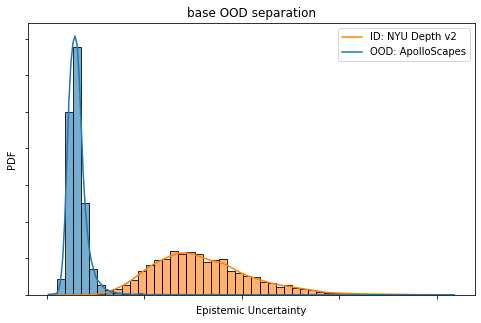

In [43]:
from scipy import stats

# 'vae', 'dropout', d, 0.65
# 'mve', 'dropout', d, 0.2
# 'mve', 'vae', d, 0.1

# load_models_combine(ds_train, ds_test, 'dropout', 'mve', d, 0.2)

num_models = 4
results_path = '/home/iaroslavelistratov/results/'

m1_name, m2_name = 'mve', 'dropout'
w = mve_dropout_avrg_best_weights[1]



m1_paths = d[m1_name]
m2_paths = d[m2_name]

l_combined_df_calibration = []
l_calibration_mse = []
l_combined_loss = []

l_combined_df_ood = []

assert len(m1_paths) == len(m2_paths) == 4
for i in range(4): #(4):
    m1_ch_dir = m1_paths[i]
    # print(m1_ch_dir)
    m2_ch_dir = m2_paths[i]
    # print(m2_ch_dir)


    # 1/3
    # note: no vae in the list, because it does not predict y_hat
    if (m1_name == 'mve' and m2_name == 'dropout'):
        m1_test_yhat, m1_test_uncertainty, m1_ood_yhat, m1_ood_uncertainty, _, _ = load_uncertainty(m1_ch_dir, m1_name)
        m2_test_yhat, m2_test_uncertainty, m_2ood_yhat, m_2ood_uncertainty, _, _ = load_uncertainty(m2_ch_dir, m2_name)

        ### test loss
        combined_y_hat = ((1 - w) * m1_test_yhat + w * m2_test_yhat)
        combined_test_loss = MSE(combined_y_hat, y_test).numpy()
        # print(combined_test_loss)
        # print(f'{i}th pair of models is {combined_test_loss}')
        l_combined_loss.append(combined_test_loss)

        ### calibrations
        # if m1_name == 'mve':
        #     m1_test_uncertainty = np.sqrt(m1_test_uncertainty)
        # combined_uncertainty = ((1 - w) * m1_test_uncertainty + w * m2_test_uncertainty)
        # percentiles, vals = gen_calibration_plot(mu=combined_y_hat, std=combined_uncertainty, y_test=y_test)
        # df_calibration = pd.DataFrame({'percentiles': percentiles, 'vals' : vals})
        # l_combined_df_calibration.append(df_calibration)
        # mse = np.mean(abs(percentiles - vals))
        # l_calibration_mse.append(mse)


        ### ood separation
        combined_iid = ((1 - w) * m1_test_uncertainty + w * m2_test_uncertainty)
        combined_iid = tf.reshape(combined_iid, (-1, 128*160)) # (3029, 128, 160, 1) -> (3029, 128*160)
        combined_iid = tf.reduce_mean(combined_iid, axis=1) # per img uncertainty

        combined_ood = ((1 - w) * m1_ood_uncertainty + w * m_2ood_uncertainty)
        combined_ood = tf.reshape(combined_ood, (-1, 128*160)) # (100, 128, 160, 1) -> (100, 128*160)
        combined_ood = tf.reduce_mean(combined_ood, axis=1) # per img uncertainty

        combined_iid, combined_ood = combined_iid[:1000], combined_ood[:1000]
        df_ood = pd.DataFrame({'id': combined_iid, 'od' : combined_ood})
        l_combined_df_ood.append(df_ood)


### ood separation
combined_df_ood = pd.concat(l_combined_df_ood, axis=0, ignore_index=True)
fig, ax = plt.subplots(figsize=(8, 5))
plt.title(f'{model_name} OOD separation')
plot = sns.histplot(data=combined_df_ood, kde=True, bins=50, alpha=0.6);
plot.set(xlabel='Epistemic Uncertainty', ylabel='PDF');
ax.legend(['ID: NYU Depth v2', 'OOD: ApolloScapes'])
plot.set(xticklabels=[]);
plot.set(yticklabels=[]);
plt.savefig('/home/iaroslavelistratov/results/figs/adhoc/ood_separation_mve+dropout.pdf', bbox_inches='tight', format='pdf')
plt.show()


# arr_combined_loss = np.array(l_combined_loss)
# mean, err = confidence_interval_95(arr_combined_loss, 'test_loss', f'{m1_name} + {m2_name}', is_return=True)
# # todo-high: note 75% CI
# confidence_interval_95(np.array(l_calibration_mse), 'calibration_mse_ci=75', model_name, ci=0.75)


# combined_df_calibration = pd.concat(l_combined_df_calibration, axis=0, ignore_index=True)
# # By default, the resulting plot shows the mean and 95% CI for each unit
# plot = sns.relplot(data=combined_df_calibration, x="percentiles", y="vals", ci=95, kind="line", color='#1f77b4')
# plt.plot([0,1], [0,1], linestyle='--', color='#ff7f0e')
# plot.set(xlabel='', ylabel='');
# plt.savefig(f'/home/iaroslavelistratov/results/figs/adhoc/calibration_95CI_mve+dropout.pdf', bbox_inches='tight', format='pdf')
# plt.show()

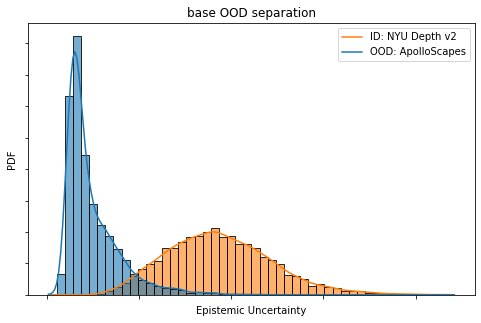

In [44]:
from scipy import stats

# 'vae', 'dropout', d, 0.65
# 'mve', 'dropout', d, 0.2
# 'mve', 'vae', d, 0.1

# load_models_combine(ds_train, ds_test, 'dropout', 'mve', d, 0.2)

num_models = 4
results_path = '/home/iaroslavelistratov/results/'

m1_name, m2_name = 'vae', 'dropout'
w = vae_dropout_avrg_best_weights[1]

m1_paths = d[m1_name]
m2_paths = d[m2_name]

l_combined_df_calibration = []
l_calibration_mse = []
l_combined_loss = []

assert len(m1_paths) == len(m2_paths) == 4
for i in range(4): #(4):
    m1_ch_dir = m1_paths[i]
    # print(m1_ch_dir)
    m2_ch_dir = m2_paths[i]
    # print(m2_ch_dir)


    # 1/3
    # note: no vae in the list, because it does not predict y_hat
    if (m1_name == 'vae' and m2_name == 'dropout'):
        _, m1_test_uncertainty, _, m1_ood_uncertainty, _, _ = load_uncertainty(m1_ch_dir, m1_name)
        m2_test_yhat, m2_test_uncertainty, m_2ood_yhat, m_2ood_uncertainty, _, _ = load_uncertainty(m2_ch_dir, m2_name)

        ### calibrations
        # combined_uncertainty = ((1 - w) * m1_test_uncertainty + w * m2_test_uncertainty)
        # percentiles, vals = gen_calibration_plot(mu=m2_test_yhat, std=combined_uncertainty, y_test=y_test)
        # df_calibration = pd.DataFrame({'percentiles': percentiles, 'vals' : vals})
        # l_combined_df_calibration.append(df_calibration)
        # mse = np.mean(abs(percentiles - vals))
        # l_calibration_mse.append(mse)

        ### ood separation
        combined_iid = ((1 - w) * m1_test_uncertainty + w * m2_test_uncertainty)
        combined_iid = tf.reshape(combined_iid, (-1, 128*160)) # (3029, 128, 160, 1) -> (3029, 128*160)
        combined_iid = tf.reduce_mean(combined_iid, axis=1) # per img uncertainty

        combined_ood = ((1 - w) * m1_ood_uncertainty + w * m_2ood_uncertainty)
        combined_ood = tf.reshape(combined_ood, (-1, 128*160)) # (100, 128, 160, 1) -> (100, 128*160)
        combined_ood = tf.reduce_mean(combined_ood, axis=1) # per img uncertainty

        combined_iid, combined_ood = combined_iid[:1000], combined_ood[:1000]
        df_ood = pd.DataFrame({'id': combined_iid, 'od' : combined_ood})
        l_combined_df_ood.append(df_ood)


### ood separation
combined_df_ood = pd.concat(l_combined_df_ood, axis=0, ignore_index=True)
fig, ax = plt.subplots(figsize=(8, 5))
plt.title(f'{model_name} OOD separation')
plot = sns.histplot(data=combined_df_ood, kde=True, bins=50, alpha=0.6);
plot.set(xlabel='Epistemic Uncertainty', ylabel='PDF');
ax.legend(['ID: NYU Depth v2', 'OOD: ApolloScapes'])
plot.set(xticklabels=[]);
plot.set(yticklabels=[]);
plt.savefig('/home/iaroslavelistratov/results/figs/adhoc/ood_separation_vae+dropout.pdf', bbox_inches='tight', format='pdf')
plt.show()


# print(f'Done: {m1_name} + {m2_name}')

# arr_combined_loss = np.array(l_combined_loss)
# mean, err = confidence_interval_95(arr_combined_loss, 'test_loss', f'{m1_name} + {m2_name}', is_return=True)
# # todo-high: note 75% CI
# confidence_interval_95(np.array(l_calibration_mse), 'calibration_mse_ci=75', model_name, ci=0.75)

# combined_df_calibration = pd.concat(l_combined_df_calibration, axis=0, ignore_index=True)
# # By default, the resulting plot shows the mean and 95% CI for each unit
# plot = sns.relplot(data=combined_df_calibration, x="percentiles", y="vals", ci=95, kind="line", color='#1f77b4')
# plt.plot([0,1], [0,1], linestyle='--', color='#ff7f0e')
# plot.set(xlabel='', ylabel='');
# plt.savefig(f'/home/iaroslavelistratov/results/figs/adhoc/calibration_95CI_vae+dropout.pdf', bbox_inches='tight', format='pdf')
# plt.show()

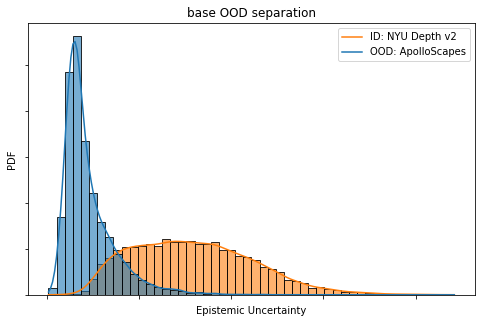

In [45]:
from scipy import stats

# 'vae', 'dropout', d, 0.65
# 'mve', 'dropout', d, 0.2
# 'mve', 'vae', d, 0.1

# load_models_combine(ds_train, ds_test, 'dropout', 'mve', d, 0.2)

num_models = 4
results_path = '/home/iaroslavelistratov/results/'

m1_name, m2_name = 'mve', 'vae'
w = mve_vae_avrg_best_weights[1]

m1_paths = d[m1_name]
m2_paths = d[m2_name]

l_combined_df_calibration = []
l_calibration_mse = []
l_combined_loss = []

assert len(m1_paths) == len(m2_paths) == 4
for i in range(4): #(4):
    m1_ch_dir = m1_paths[i]
    # print(m1_ch_dir)
    m2_ch_dir = m2_paths[i]
    # print(m2_ch_dir)


    # 1/3
    # note: no vae in the list, because it does not predict y_hat
    if (m1_name == 'mve' and m2_name == 'vae'):
        m1_test_yhat, m1_test_uncertainty, m1_ood_yhat, m1_ood_uncertainty, _, _ = load_uncertainty(m1_ch_dir, m1_name)
        _, m2_test_uncertainty, _, m_2ood_uncertainty, _, _ = load_uncertainty(m2_ch_dir, m2_name)

        # ### calibrations
        # combined_uncertainty = ((1 - w) * m1_test_uncertainty + w * m2_test_uncertainty)
        # percentiles, vals = gen_calibration_plot(mu=m1_test_yhat, std=combined_uncertainty, y_test=y_test)
        # df_calibration = pd.DataFrame({'percentiles': percentiles, 'vals' : vals})
        # l_combined_df_calibration.append(df_calibration)
        # mse = np.mean(abs(percentiles - vals))
        # l_calibration_mse.append(mse)


        ### ood separation
        combined_iid = ((1 - w) * m1_test_uncertainty + w * m2_test_uncertainty)
        combined_iid = tf.reshape(combined_iid, (-1, 128*160)) # (3029, 128, 160, 1) -> (3029, 128*160)
        combined_iid = tf.reduce_mean(combined_iid, axis=1) # per img uncertainty

        combined_ood = ((1 - w) * m1_ood_uncertainty + w * m_2ood_uncertainty)
        combined_ood = tf.reshape(combined_ood, (-1, 128*160)) # (100, 128, 160, 1) -> (100, 128*160)
        combined_ood = tf.reduce_mean(combined_ood, axis=1) # per img uncertainty

        combined_iid, combined_ood = combined_iid[:1000], combined_ood[:1000]
        df_ood = pd.DataFrame({'id': combined_iid, 'od' : combined_ood})
        l_combined_df_ood.append(df_ood)


### ood separation
combined_df_ood = pd.concat(l_combined_df_ood, axis=0, ignore_index=True)
fig, ax = plt.subplots(figsize=(8, 5))
plt.title(f'{model_name} OOD separation')
plot = sns.histplot(data=combined_df_ood, kde=True, bins=50, alpha=0.6);
plot.set(xlabel='Epistemic Uncertainty', ylabel='PDF');
ax.legend(['ID: NYU Depth v2', 'OOD: ApolloScapes'])
plot.set(xticklabels=[]);
plot.set(yticklabels=[]);
plt.savefig('/home/iaroslavelistratov/results/figs/adhoc/ood_separation_mve+vae.pdf', bbox_inches='tight', format='pdf')
plt.show()


# print(f'Done: {m1_name} + {m2_name}')

# combined_df_calibration = pd.concat(l_combined_df_calibration, axis=0, ignore_index=True)
# # By default, the resulting plot shows the mean and 95% CI for each unit
# plot = sns.relplot(data=combined_df_calibration, x="percentiles", y="vals", ci=95, kind="line", color='#1f77b4')
# plt.plot([0,1], [0,1], linestyle='--', color='#ff7f0e')
# plot.set(xlabel='', ylabel='');
# plt.savefig(f'/home/iaroslavelistratov/results/figs/adhoc/calibration_95CI_mve+vae.pdf', bbox_inches='tight', format='pdf')
# plt.show()

# arr_combined_loss = np.array(l_combined_loss)
# mean, err = confidence_interval_95(arr_combined_loss, 'test_loss', f'{m1_name} + {m2_name}', is_return=True)
# # todo-high: note 75% CI
# confidence_interval_95(np.array(l_calibration_mse), 'calibration_mse_ci=75', model_name, ci=0.75)

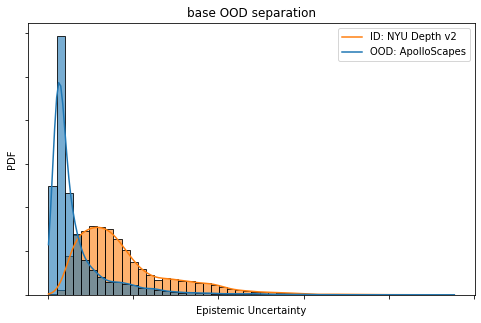

Done: vae + base


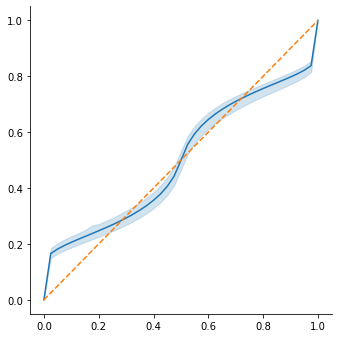

vae + base test_loss is nan ± nan
base calibration_mse_ci=75 is 0.05727 ± 0.00501


/home/iaroslavelistratov/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/iaroslavelistratov/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/iaroslavelistratov/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/iaroslavelistratov/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/iaroslavelistratov/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.

In [50]:
###### vae alone, use base to for y_hat


from scipy import stats

# 'vae', 'dropout', d, 0.65
# 'mve', 'dropout', d, 0.2
# 'mve', 'vae', d, 0.1

# load_models_combine(ds_train, ds_test, 'dropout', 'mve', d, 0.2)

num_models = 4
results_path = '/home/iaroslavelistratov/results/'

m1_name, m2_name = 'vae', 'base'
w = mve_vae_avrg_best_weights[1]

m1_paths = d[m1_name]
m2_paths = d[m2_name]

l_combined_df_calibration = []
l_calibration_mse = []
l_combined_loss = []

assert len(m1_paths) == len(m2_paths) == 4
for i in range(4): #(4):
    m1_ch_dir = m1_paths[i]
    # print(m1_ch_dir)
    m2_ch_dir = m2_paths[i]
    # print(m2_ch_dir)


    # 1/3
    # note: no vae in the list, because it does not predict y_hat
    if (m1_name == 'vae' and m2_name == 'base'):
        _, m1_test_uncertainty, _, m1_ood_uncertainty, _, _ = load_uncertainty(m1_ch_dir, m1_name)
        m2_test_yhat, _, m2_ood_yhat, _, _, _ = load_uncertainty(m2_ch_dir, m2_name)

        # ### calibrations
        percentiles, vals = gen_calibration_plot(mu=m2_test_yhat, std=m1_test_uncertainty, y_test=y_test)
        df_calibration = pd.DataFrame({'percentiles': percentiles, 'vals' : vals})
        l_combined_df_calibration.append(df_calibration)
        mse = np.mean(abs(percentiles - vals))
        l_calibration_mse.append(mse)


        ### ood separation
        iid = tf.reshape(m1_test_uncertainty, (-1, 128*160)) # (3029, 128, 160, 1) -> (3029, 128*160)
        iid = tf.reduce_mean(iid, axis=1) # per img uncertainty

        ood = tf.reshape(m1_ood_uncertainty, (-1, 128*160)) # (100, 128, 160, 1) -> (100, 128*160)
        ood = tf.reduce_mean(ood, axis=1) # per img uncertainty

        iid, ood = iid[:1000], ood[:1000]
        df_ood = pd.DataFrame({'id': iid, 'od' : ood})
        l_combined_df_ood.append(df_ood)


### ood separation
combined_df_ood = pd.concat(l_combined_df_ood, axis=0, ignore_index=True)
fig, ax = plt.subplots(figsize=(8, 5))
plt.title(f'{model_name} OOD separation')
plot = sns.histplot(data=combined_df_ood, kde=True, bins=50, alpha=0.6);
plot.set(xlabel='Epistemic Uncertainty', ylabel='PDF');
ax.legend(['ID: NYU Depth v2', 'OOD: ApolloScapes'])
plot.set(xticklabels=[]);
plot.set(yticklabels=[]);
plt.savefig('/home/iaroslavelistratov/results/figs/adhoc/ood_separation_vae.pdf', bbox_inches='tight', format='pdf')
plt.show()


print(f'Done: {m1_name} + {m2_name}')

combined_df_calibration = pd.concat(l_combined_df_calibration, axis=0, ignore_index=True)
# By default, the resulting plot shows the mean and 95% CI for each unit
plot = sns.relplot(data=combined_df_calibration, x="percentiles", y="vals", ci=95, kind="line", color='#1f77b4')
plt.plot([0,1], [0,1], linestyle='--', color='#ff7f0e')
plot.set(xlabel='', ylabel='');
plt.savefig(f'/home/iaroslavelistratov/results/figs/adhoc/calibration_95CI_vae.pdf', bbox_inches='tight', format='pdf')
plt.show()

arr_combined_loss = np.array(l_combined_loss)
mean, err = confidence_interval_95(arr_combined_loss, 'test_loss', f'{m1_name} + {m2_name}', is_return=True)
# todo-high: note 75% CI
confidence_interval_95(np.array(l_calibration_mse), 'calibration_mse_ci=75', model_name, ci=0.75)

## Confidence plots

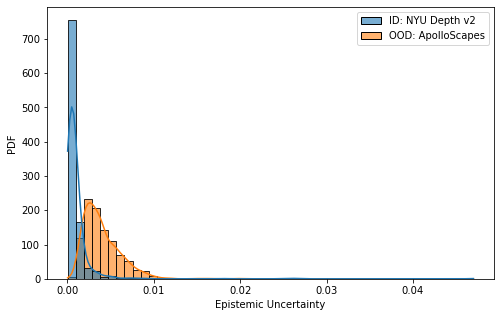

In [ ]:
def _iter_and_cat(ds, model, T, reduce='per_img'):
    ds_itter = ds.as_numpy_iterator()
    ll = []

    for x, y in ds_itter: # (32, 128, 160, 3), (32, 128, 160, 1)

        if model.metric_name in ['dropout']:
            _, uncertainty = model(x, T=T) # (B, 128, 160, 1), (B, 128, 160, 1)
        elif model.metric_name in ['mve', 'ae', 'ensemble']:
            _, uncertainty = model(x)
        elif model.metric_name in ['vae']:
            _, _, _, uncertainty = model(x, T=T)

        B = uncertainty.shape[0]
        uncertainty = tf.reshape(uncertainty, [B, 128*160]) # (B, 128, 160, 1) -> (B, 20480)

        # reduce scenario 1 - axis=[0, 1] is per batch  (B, 20480) -> ( ,)
        if reduce == 'per_batch':
            uncertainty = tf.reduce_mean(uncertainty, axis=[0, 1]) 
        # reduce scenario 2 - axis=1 is per image  (B, 20480) -> (B, )
        elif reduce == 'per_img':
            uncertainty = tf.reduce_mean(uncertainty, axis=1)

        ll.append(uncertainty)
    cat = tf.concat(ll, axis=0) # (B->N, ...)

    # reduce scenario 3 - axis=[0] is per pixel -> (N, 20480) -> (20480, )
    if reduce == 'per_pixel':
        assert cat.shape[1:] == (20480)
        cat = tf.reduce_mean(cat, axis=0)

    return cat

iid = _iter_and_cat(ds_test, mve_model, T=1)
ood = _iter_and_cat(ds_ood, mve_model, T=1)

N = min(iid.shape[0], ood.shape[0])
iid, ood = iid[:N], ood[:N]
df = pd.DataFrame({'ID: NYU Depth v2': iid, 'OOD: ApolloScapes' : ood})

fig, ax = plt.subplots(figsize=(8, 5))  
plot = sns.histplot(data=df, kde=True, bins=50, alpha=0.6);
plot.set(xlabel='Epistemic Uncertainty', ylabel='PDF');

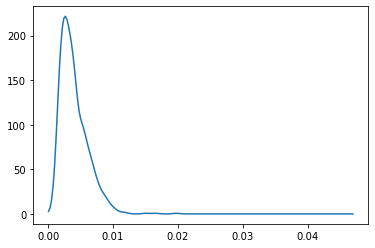

In [ ]:
line = sns.histplot(data=df, kde=True, bins=50, alpha=0.6).get_lines()[0]
plt.close()
plt.plot(line.get_xdata(), line.get_ydata())

In [ ]:
[h.get_height() for h in sns.histplot(data=df, kde=True, bins=50, alpha=0.6).patches]

In [ ]:
# # This returns two numpy arrays containing the x and y values for the line.
# x, y = sns.histplot(data=df, kde=True, bins=50, alpha=0.6).get_lines()[0].get_data()
# plt.close()
# plt.plot(x, y)

In [312]:
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Random numbers for plotting
# x = np.random.uniform(-2, 2, 1000)
# y = np.random.normal(x**2, np.abs(x) + 1)

# # Manual binning to retain control
# binwidth = 4 / 10
# x_bins = np.arange(binwidth/2 - 2, 2, binwidth)
# sns.regplot(x=x, y=y, x_bins=x_bins, fit_reg=None)

In [313]:
# # More complex datasets will have multiple measurements for the same value of the x variable. The default behavior in seaborn is to aggregate the multiple measurements at each x value by plotting the mean and the 95% confidence interval around the mean:
# fmri = sns.load_dataset("fmri")
# sns.relplot(data=fmri, x="timepoint", y="signal", kind="line")

In [213]:
# import numpy as np
# import scipy.stats

# def mean_confidence_interval(data, confidence=0.95):
#     sample_size = len(data) - 1
#     m, se = np.mean(data), scipy.stats.sem(data)
#     print(scipy.stats.sem(data))
#     h = se * scipy.stats.t.ppf((1 + confidence) / 2., sample_size)
#     print('h', h)
#     return m, m-h, m+h

# mean_confidence_interval(combined_df_loss['loss'])

0.0002148560838904735
h 0.0006837679503450831


(0.0939258865, 0.09324211854965492, 0.09460965445034508)

In [208]:
# from scipy.stats import norm
# from scipy.stats import t

# def confidence_interval_95(sample_size, sample_mean, sample_std):

#     # standerd error of the mean is a spatial way of saying the std of the sampling distibtuion
#     standard_error = sample_std / np.sqrt(sample_size)

#     ### confidece interval
#     degrees_of_freedom = sample_size - 1
#     ## t values for 2-tail
#     # confidence_interval = t.ppf(1 - (0.05/2), degrees_of_freedom)
#     lower_cutoff = t.ppf(0.025, degrees_of_freedom)
#     upper_cutoff = t.ppf(0.975, degrees_of_freedom)
#     ## t values for a single tail
#     # print(t.ppf(1 - 0.05, degrees_of_freedom))

#     print(f'standard error is {round(standard_error, 2)}')
#     print(f'confidence interval is {round(confidence_interval, 2)}\n')

#     interval = round(confidence_interval * standard_error, 2)
#     print(f'95% confidence interval is : {sample_mean} ± {interval}')
#     print(f'lower bound is : {sample_mean - interval}')
#     print(f'upper bound is : {sample_mean + interval}')

# confidence_interval_95(
#     sample_size=combined_df_loss['loss'].shape[0],
#     sample_mean=combined_df_loss['loss'].mean(),
#     sample_std=combined_df_loss['loss'].std(),
# )

## Else

### – Quantify OD separation

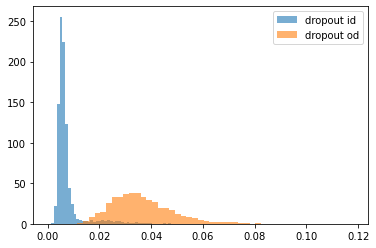

In [ ]:
# We can also normalize our inputs by the total number of counts

# todo-high:
# If True, draw and return a probability density: each bin will display the bin's raw count divided by the total number of counts and the bin width (density = counts_in_this_bin / total_counts  / width_of_the_bin), so that the area under the histogram integrates to 1 (np.sum(density * np.diff(bins)) == 1).
# If stacked is also True, the sum of the histograms is normalized to 1.

out = plt.hist(dropout_iid, bins=50, alpha=0.6, label='dropout id', density=True)
plt.hist(dropout_ood, bins=50, alpha=0.6, label='dropout od', density=True)

plt.legend(loc='upper right')
plt.show()

In [ ]:
hights = out[0]
widths = np.diff(out[1])
np.sum(hights * widths)

1.0

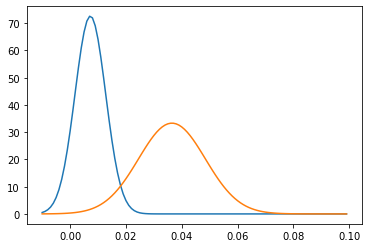

In [ ]:
# can approximate then with gaussians

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Plot between -10 and 10 with .001 steps.
x_axis = np.arange(-.01, .10, 0.001)

mu_id = np.mean(dropout_iid)
std_id = np.std(dropout_iid)

mu_od = np.mean(dropout_ood)
std_od = np.std(dropout_ood)

plt.plot(x_axis, norm.pdf(x_axis, mu_id, std_id))
plt.plot(x_axis, norm.pdf(x_axis, mu_od, std_od))
plt.show()

### – Another OOD ds

In [ ]:
import pathlib

data_dir = pathlib.Path('/home/iaroslavelistratov/data/ood_miniplaces')
ood_places_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(128, 160),
    batch_size=32,
)

ood_places_ds = ood_places_ds.map(lambda x, y: (x/255., y))

Found 10000 files belonging to 1 classes.


In [ ]:
# visualize_vae_depth_map(trained_model, ood_places_ds, vis_path, f'trained_ood', is_show=True)

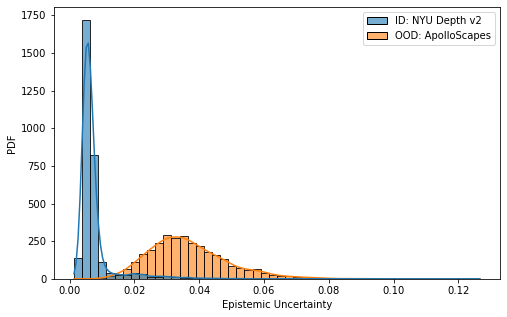

In [ ]:
dropout_iid, dropout_ood = gen_ood_comparison(ds_test, ood_places_ds, dropout_model, T=5, reduce='per_img', is_show=True, is_return=True)

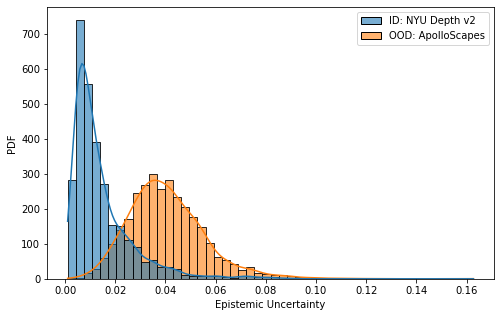

In [ ]:
ae_iid, ae_ood = gen_ood_comparison(ds_test, ood_places_ds, ae_model, reduce='per_img', is_show=True, is_return=True)

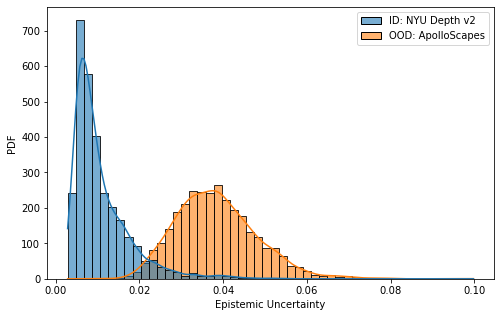

In [ ]:
combined_iid = tf.reduce_mean(tf.stack([dropout_iid, ae_iid], axis=0), axis=0)
combined_ood = tf.reduce_mean(tf.stack([dropout_ood, ae_ood], axis=0), axis=0)

df = pd.DataFrame({'ID: NYU Depth v2': combined_iid, 'OOD: ApolloScapes' : combined_ood})

fig, ax = plt.subplots(figsize=(8, 5))  
plot = sns.histplot(data=df, kde=True, bins=50, alpha=0.6);
plot.set(xlabel='Epistemic Uncertainty', ylabel='PDF');

plt.show()